In [1]:
!pip install -q -U trax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 637.9/637.9 kB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 83.4 MB/s eta 0:00:00


#### Data Preparation

In [40]:
import numpy as np
import random
import trax

from trax import shapes
from trax import layers as tl
from trax.fastmath import numpy as fastnp
from trax.supervised import training

In [ ]:
DATA_DIR = 'data/'
OUTPUT_DIR = 'output/'

VOCAB_DIR = 'data/'
VOCAB_FILE = 'ende_32k.subword'

Pipeline Step

1. Load Tensorflow Dataset
2. Tokenize sentence using subword representation
3. Append an end-of-sentence token to each sentence
4. Shuffle data
5. Filter long sentences
6. [Bucketing](https://rashmi-margani.medium.com/how-to-speed-up-the-training-of-the-sequence-model-using-bucketing-techniques-9e302b0fd976)
7. Add Loss Weights


In [4]:
# integer assigned as end-of-sentence (EOS)
EOS = 1

In [5]:
# generator helper function to append EOS to each sentence
def append_eos(stream):
  for (inputs, targets) in stream:
    inputs_with_eos = list(inputs) + [EOS]
    targets_with_eos = list(targets) + [EOS]

    yield np.array(inputs_with_eos), np.array(targets_with_eos)

In [63]:
train_data_pipeline = trax.data.Serial(
    trax.data.TFDS('opus/medical', data_dir=DATA_DIR, keys=('en', 'de'), eval_holdout_size=0.01, train=True),
    trax.data.Tokenize(vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR),
    lambda _: append_eos(_),
    trax.data.Shuffle(),
    trax.data.FilterByLength(max_length=256, length_keys=[0, 1]),
    trax.data.BucketByLength(boundaries=[8, 16, 32, 64, 128, 256, 512],
                             batch_sizes=[256, 128, 64, 32, 16, 8, 4, 2],
                             length_keys=[0, 1]),
    trax.data.AddLossWeights(id_to_mask=0)
)

In [64]:
eval_data_pipeline = trax.data.Serial(
    trax.data.TFDS('opus/medical', data_dir=DATA_DIR, keys=('en', 'de'), eval_holdout_size=0.01, train=False),
    trax.data.Tokenize(vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR),
    lambda _: append_eos(_),
    trax.data.Shuffle(),
    trax.data.FilterByLength(max_length=512, length_keys=[0, 1]),
    trax.data.BucketByLength(boundaries=[8, 16, 32, 64, 128, 256, 512],
                             batch_sizes=[256, 128, 64, 32, 16, 8, 4, 2],
                             length_keys=[0, 1]),
    trax.data.AddLossWeights(id_to_mask=0)
)

In [65]:
def detokenize(input, vocab_file=None, vocab_dir=None):
    input = list(np.squeeze(input))

    if EOS in input:
        input = input[:input.index(EOS)]

    return trax.data.detokenize(input, vocab_file=vocab_file, vocab_dir=vocab_dir)

In [66]:
train_batch_stream = train_data_pipeline()

In [67]:
eval_batch_stream = eval_data_pipeline()

In [11]:
input_batch, target_batch, mask_batch = next(train_batch_stream)

In [12]:
index = random.randrange(len(input_batch))

In [13]:
print('ENGLISH SENTENCE:')
print(detokenize(input_batch[index], vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR))

print('TOKENIZED VERSION OF THE ENGLISH SENTENCE:')
print(input_batch[index])

print('GERMAN TRANSLATION:')
print(detokenize(target_batch[index], vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR))

print('TOKENIZED VERSION OF THE GERMAN TRANSLATION:')
print(target_batch[index])

ENGLISH SENTENCE:
For patients that require haemodialysis and in patients with severe renal impairment (GFR < 30 ml/ min), the dose should be reduced by 50%.

TOKENIZED VERSION OF THE ENGLISH SENTENCE:
[  327  4996    17  1603  5802  6165 19693  5876  3657    16     8     6
  4996    30  4976 12038   215 23650   669    50 18520  1013   909 33287
   913   448  7272     5  6722  5251   224     4 20441   117    32  3372
    45   563  9935  3550 30650  4729   992     1     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
GERMAN TRANSLATION:
Bei hämodialysepflichtigen Patien- ten sowie Patienten mit schwerer Beeinträchtigung der Nierenfunktion (GFR < 30 ml/min) sollte die Dosis um 50% reduziert werden.

TOKENIZED VERSION OF THE GERMAN TRANSLATION:
[  752  7310 17043  5876  3657  4472 20233  1570  7478  2696   159   177
   274  5122    39 10948 14393 28710 26565   147    11  6262  4594 17422
    50 18520  1013   909 33287 

#### Model Architecture

##### Encoder Decoder

Tokenized version of a sentence in its encoder, then passes it on to the decoder for translation

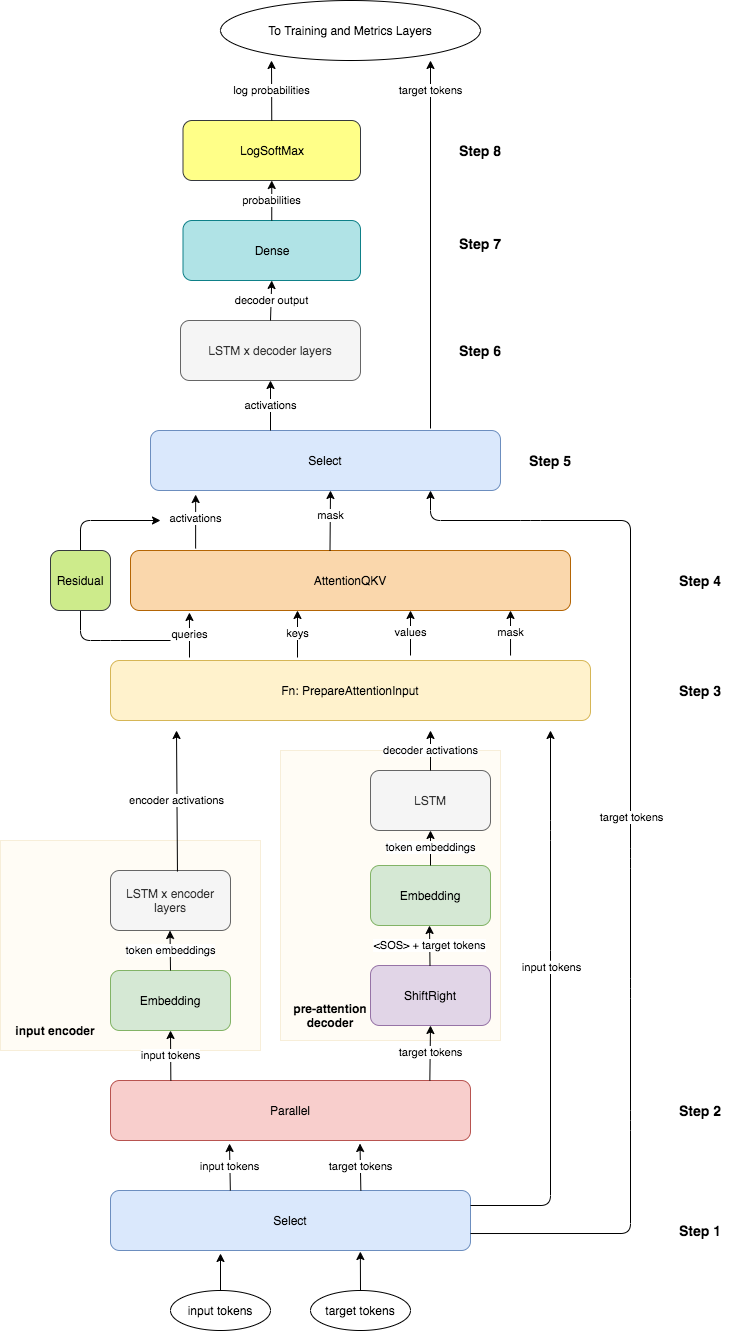

In [68]:
VOCAB_SIZE = 33000
D_FEATURE = 1024

N_ENCODER_LAYERS = 2
N_DECODER_LAYERS = 2
N_ATTENTION_HEADS = 4

ATTENTION_DROPOUT = 0.0

In [69]:
input_encoder = tl.Serial(
    tl.Embedding(vocab_size=VOCAB_SIZE, d_feature=D_FEATURE),
    [tl.LSTM(n_units=D_FEATURE) for _ in range(N_ENCODER_LAYERS)]
)

In [70]:
def pre_attention_decoder_fn(mode='train'):
  return tl.Serial(
      tl.ShiftRight(mode=mode),
      tl.Embedding(vocab_size=VOCAB_SIZE, d_feature=D_FEATURE),
      tl.LSTM(n_units=D_FEATURE)
  )

In [71]:
def prepare_attention_input(encoder_activations, decoder_activations, input_tokens):
  keys = values = encoder_activations
  queries = decoder_activations

  # multiheaded attention
  mask = input_tokens != 0
  mask = fastnp.reshape(mask, (mask.shape[0], 1, 1, mask.shape[1]))
  mask = mask + fastnp.zeros((1, 1, decoder_activations.shape[1], 1))

  return queries, keys, values, mask

In [72]:
def model_fn(mode='train'):
  return tl.Serial(
    tl.Select([0,1,0,1]),
    tl.Parallel(input_encoder, pre_attention_decoder_fn(mode)),
    tl.Fn('PrepareAttentionInput', prepare_attention_input, n_out=4),
    tl.Residual(tl.AttentionQKV(D_FEATURE, n_heads=N_ATTENTION_HEADS, dropout=ATTENTION_DROPOUT, mode=mode)),
    tl.Select([0,2]),
    [tl.LSTM(n_units=D_FEATURE) for _ in range(N_DECODER_LAYERS)],
    tl.Dense(VOCAB_SIZE),
    tl.LogSoftmax()
  )

In [73]:
model = model_fn()

In [74]:
print(model)

Serial_in2_out2[
  Select[0,1,0,1]_in2_out4
  Parallel_in2_out2[
    Serial[
      Embedding_33000_1024
      LSTM_1024
      LSTM_1024
    ]
    Serial[
      Serial[
        ShiftRight(1)
      ]
      Embedding_33000_1024
      LSTM_1024
    ]
  ]
  PrepareAttentionInput_in3_out4
  Serial_in4_out2[
    Branch_in4_out3[
      None
      Serial_in4_out2[
        _in4_out4
        Serial_in4_out2[
          Parallel_in3_out3[
            Dense_1024
            Dense_1024
            Dense_1024
          ]
          PureAttention_in4_out2
          Dense_1024
        ]
        _in2_out2
      ]
    ]
    Add_in2
  ]
  Select[0,2]_in3_out2
  LSTM_1024
  LSTM_1024
  Dense_33000
  LogSoftmax
]


In [81]:
batch = next(train_batch_stream)

In [ ]:
model.init(shapes.signature(batch))

#### Training Model

In [86]:
train_task = training.TrainTask(
    labeled_data= train_batch_stream,
    loss_layer= tl.CrossEntropyLossWithLogSoftmax(),
    optimizer= trax.optimizers.Adafactor(learning_rate=0.001, epsilon1=1e-30),
    lr_schedule= trax.lr.multifactor(constant=1.0, warmup_steps=500),
    n_steps_per_checkpoint= 100,
)

In [88]:
eval_task = training.EvalTask(
    labeled_data=eval_batch_stream,
    metrics=[tl.CrossEntropyLossWithLogSoftmax(), tl.WeightedCategoryAccuracy()],
)

In [ ]:
training_loop = training.Loop(model,
                              train_task,
                              eval_tasks=[eval_task],
                              output_dir=OUTPUT_DIR)

In [90]:
training_loop.run(10)

/usr/local/lib/python3.10/dist-packages/trax/layers/base.py:851: FutureWarning: GzipFile was opened for writing, but this will change in future Python releases.  Specify the mode argument for opening it for writing.
  with gzip.GzipFile(fileobj=f, compresslevel=compresslevel) as gzipf:



Step      1: Total number of trainable weights: 147570920
Step      1: Ran 1 train steps in 90.06 secs
Step      1: train CrossEntropyLossWithLogSoftmax |  10.12506008


/usr/local/lib/python3.10/dist-packages/trax/supervised/training.py:1249: FutureWarning: GzipFile was opened for writing, but this will change in future Python releases.  Specify the mode argument for opening it for writing.
  with gzip_lib.GzipFile(fileobj=f, compresslevel=2) as gzipf:


Step      1: eval  CrossEntropyLossWithLogSoftmax |  10.17314816
Step      1: eval        WeightedCategoryAccuracy |  0.02824859
